In [1]:
# module import
import os
import sys
from datetime import datetime
import pickle

import numpy as np
import PIL.Image
import torch
import torchvision
                
sys.path.append('../cnn_preferred')
from utils import normalise_img, clip_extreme_pixel, save_video, normalise_vid, get_cnn_features, img_deprocess, get_target_feature_shape
from activation_maximization import generate_preferred

In [ ]:
net = torchvision.models.resnet50(pretrained=True)
net.eval()

In [138]:
# moment in time
weight_file = '../model/resnet50/moments_RGB_resnet50_imagenetpretrained.pth.tar'
net = torchvision.models.__dict__['resnet50'](num_classes=339)
checkpoint = torch.load(weight_file, map_location=lambda storage,
                                    loc: storage)
state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
net.load_state_dict(state_dict)
net.eval()

# image mean and std for pre/de-process image for input network
img_mean=np.array([0.485, 0.456, 0.406],dtype=np.float),
img_std = np.array([0.229,0.224,0.225])


# if the model input is for 0-1 range, norm = 255, elif 0-255, norm = 1
norm = 255

In [118]:
# place 365
weight_file = '../model/resnet50/resnet50_places365.pth.tar'
net = torchvision.models.__dict__['resnet50'](num_classes=365)
checkpoint = torch.load(weight_file, map_location=lambda storage,
                                    loc: storage)
state_dict = {str.replace(k, 'module.', ''): v for k, v in checkpoint['state_dict'].items()}
net.load_state_dict(state_dict)
net.eval()

# image mean and std for pre/de-process image for input network
img_mean=np.array([0.485, 0.456, 0.406],dtype=np.float),
img_std = np.array([0.229,0.224,0.225])

# if the model input is for 0-1 range, norm = 255, elif 0-255, norm = 1
norm = 255

In [127]:
# VGGface2
weight_file = '../model/resnet50/resnet50_ft_weight.pkl'
with open(weight_file, 'rb') as f:
    weights = pickle.load(f, encoding='latin1')
net = torchvision.models.__dict__['resnet50'](num_classes=8631)
own_state = net.state_dict()
for name, param in weights.items():
    if name in own_state:
        try:
            own_state[name].copy_(torch.from_numpy(param))
        except Exception:
            raise RuntimeError('While copying the parameter named {}, whose dimensions in the model are {} and whose '\
                               'dimensions in the checkpoint are {}.'.format(name, own_state[name].size(), param.size()))
    else:
        raise KeyError('unexpected key "{}" in state_dict'.format(name))

net.eval()
img_mean = np.array([93.5940,104.7624, 129.1863])
#img_mean =np.array([0,0,0])
img_std = np.array([1,1,1])
norm = 1

In [139]:
#save_dir
save_dir = '../result'
save_folder = 'jupyter_demo_torch_complexCNN_conv'
save_folder = save_folder + '_' + datetime.now().strftime('%Y%m%dT%H%M%S')
save_path = os.path.join(save_dir,save_folder)
os.makedirs(save_path, exist_ok=True)

In [140]:
# initial image for the optimization
h, w = 299,299
h,w = 224, 224
initial_input = np.random.randint(0, 256, (h,w,3))

In [141]:
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [142]:
target_layer = "net.classifier[6]"
target_layer = "net.features.denseblock1.denselayer2.conv1"
#target_layer = "net.features.conv0"
#target_layer = "net.Conv2d_2a_3x3.conv"
target_layer = "net.fc"


In [143]:
#target layer setting
exec_str_list = [target_layer +".register_forward_hook(hook)"]
## obtain target feature shape
# transform input shape for torch avairable shape
initial_torch_input = torch.Tensor(initial_input.transpose(2,0, 1)[np.newaxis])
# obtain target layer activation 
feat_shape = get_target_feature_shape(net, initial_torch_input, exec_str_list)

In [144]:
feat_shape

(1, 339)

In [145]:
# options
opts = {
    'img_mean': img_mean, #img_mean to preprocessing input image
    'img_std': img_std,   #img_std to preprocessing input image
    'norm': norm,         #if the model input is for 0-1 range, norm = 255, elif 0-255, norm = 1
    
    'iter_n': 200, # the total number of iterations for gradient descend

    'disp_every': 1, # display the information on the terminal for every n iterations

    'save_intermediate': True, # save the intermediate or not
    'save_intermediate_every': 10, # save the intermediate for every n iterations
    'save_intermediate_path': save_path, # the path to save the intermediate

    'lr_start':1 , # learning rate
    'lr_end': 1 ,   # we can change learning rate linearly setteing these two parameters

    'momentum_start': 0.001, # gradient with momentum
    'momentum_end': 0.001,   # we can change momentum linearly setteing these two parameters too

    'decay_start': 0.001, # pixel decay for each iteration
    'decay_end': 0.001,   # we can also change pixel decay linealy 

    'image_blur': True, # Use image smoothing or not
    'sigma_start': 2.5, # the size of the gaussian filter for image smoothing
    'sigma_end': 0.5,

    'image_jitter': True, # use image jittering during optimization
    'jitter_size': 32,
    
    'use_p_norm_reg': False, # use p_norm regularization
    'p': 2,

    'use_TV_norm_reg': False,
    'TVbeta1': 1, 
    'TVbeta2':1.2,

    'clip_small_norm': True,
    'clip_small_norm_every': 1,
    'n_pct_start': 5,
    'n_pct_end': 5,

    'clip_small_contribution': True,
    'clip_small_contribution_every': 1,
    'c_pct_start': 5,
    'c_pct_end':5,
    
    'input_size': (224,224,3),
    'initial_input': initial_input, # the initial image for the optimization (setting to None will use random noise as initial image)
    }



In [146]:
channel_list = [14,56, 123, 124, 215]

In [147]:
for channel in channel_list:
    #
    print('')
    print('channel='+str(channel))
    print('')

    # target units
    feat_size = feat_shape
    #y_index = int(feat_size[2]/2) # the unit in the center of feature map
    #x_index = int(feat_size[3]/2) # the unit in the center of feature map
    feature_mask = np.zeros(feat_size)
    #feature_mask[0,channel,y_index,x_index] = 1
    
    feature_mask[0,channel] = 1
    #feature_mask[0,:] = 1
    # weights for the target units
    feature_weight = np.zeros(feat_size, dtype=np.float32)
    #feature_weight[0,:] = -1000
    feature_weight[0,channel] = 1
    
    #
    preferred_stim = generate_preferred(net, exec_str_list, feature_mask=feature_mask, **opts)
    # save the results
    save_name = 'preferred_img' + '_layer_' + str(target_layer) + '_channel_' + str(channel) + '.npy'
    np.save(os.path.join(save_path,save_name), preferred_stim)

    save_name = 'preferred_img' + '_layer_' + str(target_layer) + '_channel_' + str(channel) + '.jpg'
    #save_video(normalise_vid(clip_extreme_pixel(preferred_stim,pct=0.04)), save_name, save_path )
    PIL.Image.fromarray(normalise_img(clip_extreme_pixel(preferred_stim, pct=0.04))).save(
                    os.path.join(save_path, save_name))


channel=14

iter=1; mean(abs(feat))=0.449966;
iter=2; mean(abs(feat))=1.52061;
iter=3; mean(abs(feat))=0.210658;
iter=4; mean(abs(feat))=1.02911;
iter=5; mean(abs(feat))=0.0953178;
iter=6; mean(abs(feat))=2.75036;
iter=7; mean(abs(feat))=2.27825;
iter=8; mean(abs(feat))=1.15149;
iter=9; mean(abs(feat))=4.42386;
iter=10; mean(abs(feat))=2.55072;
iter=11; mean(abs(feat))=3.17129;
iter=12; mean(abs(feat))=3.9935;
iter=13; mean(abs(feat))=4.85886;
iter=14; mean(abs(feat))=5.09552;
iter=15; mean(abs(feat))=6.04222;
iter=16; mean(abs(feat))=6.29169;
iter=17; mean(abs(feat))=5.26597;
iter=18; mean(abs(feat))=6.16393;
iter=19; mean(abs(feat))=6.65605;
iter=20; mean(abs(feat))=5.53953;
iter=21; mean(abs(feat))=5.85307;
iter=22; mean(abs(feat))=6.59111;
iter=23; mean(abs(feat))=5.91906;
iter=24; mean(abs(feat))=6.8104;
iter=25; mean(abs(feat))=6.27238;
iter=26; mean(abs(feat))=6.59007;
iter=27; mean(abs(feat))=5.62642;
iter=28; mean(abs(feat))=7.03699;
iter=29; mean(abs(feat))=6.65212;
iter=30;

iter=40; mean(abs(feat))=18.4334;
iter=41; mean(abs(feat))=18.195;
iter=42; mean(abs(feat))=18.068;
iter=43; mean(abs(feat))=17.4371;
iter=44; mean(abs(feat))=20.2675;
iter=45; mean(abs(feat))=21.0419;
iter=46; mean(abs(feat))=17.4411;
iter=47; mean(abs(feat))=17.945;
iter=48; mean(abs(feat))=16.6373;
iter=49; mean(abs(feat))=18.9615;
iter=50; mean(abs(feat))=20.399;
iter=51; mean(abs(feat))=19.3342;
iter=52; mean(abs(feat))=17.7082;
iter=53; mean(abs(feat))=20.1894;
iter=54; mean(abs(feat))=22.8162;
iter=55; mean(abs(feat))=20.0904;
iter=56; mean(abs(feat))=18.9504;
iter=57; mean(abs(feat))=20.1974;
iter=58; mean(abs(feat))=17.8344;
iter=59; mean(abs(feat))=21.1758;
iter=60; mean(abs(feat))=15.2009;
iter=61; mean(abs(feat))=22.7276;
iter=62; mean(abs(feat))=19.517;
iter=63; mean(abs(feat))=20.8003;
iter=64; mean(abs(feat))=20.7278;
iter=65; mean(abs(feat))=19.9248;
iter=66; mean(abs(feat))=21.0458;
iter=67; mean(abs(feat))=21.8434;
iter=68; mean(abs(feat))=18.5873;
iter=69; mean(abs(f

iter=79; mean(abs(feat))=13.6703;
iter=80; mean(abs(feat))=16.2559;
iter=81; mean(abs(feat))=13.1643;
iter=82; mean(abs(feat))=13.9808;
iter=83; mean(abs(feat))=15.4955;
iter=84; mean(abs(feat))=12.8368;
iter=85; mean(abs(feat))=17.0471;
iter=86; mean(abs(feat))=16.4458;
iter=87; mean(abs(feat))=14.6318;
iter=88; mean(abs(feat))=14.7908;
iter=89; mean(abs(feat))=13.6151;
iter=90; mean(abs(feat))=10.445;
iter=91; mean(abs(feat))=14.8086;
iter=92; mean(abs(feat))=13.1126;
iter=93; mean(abs(feat))=14.4338;
iter=94; mean(abs(feat))=15.1968;
iter=95; mean(abs(feat))=15.9122;
iter=96; mean(abs(feat))=17.5306;
iter=97; mean(abs(feat))=16.4942;
iter=98; mean(abs(feat))=18.7167;
iter=99; mean(abs(feat))=17.2564;
iter=100; mean(abs(feat))=15.691;
iter=101; mean(abs(feat))=15.095;
iter=102; mean(abs(feat))=15.1596;
iter=103; mean(abs(feat))=17.8376;
iter=104; mean(abs(feat))=14.2701;
iter=105; mean(abs(feat))=18.1931;
iter=106; mean(abs(feat))=15.8615;
iter=107; mean(abs(feat))=18.3748;
iter=108;

iter=118; mean(abs(feat))=27.8798;
iter=119; mean(abs(feat))=24.9389;
iter=120; mean(abs(feat))=26.648;
iter=121; mean(abs(feat))=20.7265;
iter=122; mean(abs(feat))=26.7443;
iter=123; mean(abs(feat))=25.7786;
iter=124; mean(abs(feat))=26.05;
iter=125; mean(abs(feat))=24.0604;
iter=126; mean(abs(feat))=23.8319;
iter=127; mean(abs(feat))=25.0455;
iter=128; mean(abs(feat))=26.8516;
iter=129; mean(abs(feat))=19.526;
iter=130; mean(abs(feat))=25.5474;
iter=131; mean(abs(feat))=30.5549;
iter=132; mean(abs(feat))=24.836;
iter=133; mean(abs(feat))=17.7824;
iter=134; mean(abs(feat))=23.4796;
iter=135; mean(abs(feat))=23.4817;
iter=136; mean(abs(feat))=29.5876;
iter=137; mean(abs(feat))=16.0203;
iter=138; mean(abs(feat))=21.1;
iter=139; mean(abs(feat))=21.3677;
iter=140; mean(abs(feat))=19.7945;
iter=141; mean(abs(feat))=20.105;
iter=142; mean(abs(feat))=25.3335;
iter=143; mean(abs(feat))=29.4465;
iter=144; mean(abs(feat))=22.7698;
iter=145; mean(abs(feat))=29.4955;
iter=146; mean(abs(feat))=26.

iter=156; mean(abs(feat))=14.6337;
iter=157; mean(abs(feat))=14.3252;
iter=158; mean(abs(feat))=13.8733;
iter=159; mean(abs(feat))=14.3089;
iter=160; mean(abs(feat))=13.7783;
iter=161; mean(abs(feat))=18.1054;
iter=162; mean(abs(feat))=17.4462;
iter=163; mean(abs(feat))=13.2005;
iter=164; mean(abs(feat))=14.888;
iter=165; mean(abs(feat))=15.7068;
iter=166; mean(abs(feat))=14.0749;
iter=167; mean(abs(feat))=15.4708;
iter=168; mean(abs(feat))=13.7545;
iter=169; mean(abs(feat))=12.8761;
iter=170; mean(abs(feat))=15.9232;
iter=171; mean(abs(feat))=17.7357;
iter=172; mean(abs(feat))=14.5173;
iter=173; mean(abs(feat))=14.0295;
iter=174; mean(abs(feat))=18.3316;
iter=175; mean(abs(feat))=12.4229;
iter=176; mean(abs(feat))=14.2783;
iter=177; mean(abs(feat))=12.8302;
iter=178; mean(abs(feat))=13.6719;
iter=179; mean(abs(feat))=14.3107;
iter=180; mean(abs(feat))=13.0302;
iter=181; mean(abs(feat))=13.8427;
iter=182; mean(abs(feat))=8.98038;
iter=183; mean(abs(feat))=13.1836;
iter=184; mean(abs(fe

In [137]:
ee= get_cnn_features(net, torch.Tensor(preferred_stim.transpose(2,0,1)[np.newaxis]), exec_str_list)

In [80]:
import matplotlib.pyplot as plt

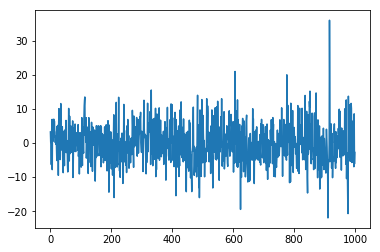

In [240]:
plt.plot(ee[0].detach().numpy()[0])

In [88]:
net.classifier.weight.detach().numpy().min()

-0.29465234